In [1]:
import pandas as pd
import numpy as np
import torch 
from torch import nn
import torch.nn.functional as F
from torchvision import datasets
import torchvision
import requests
from pathlib import Path
import os
import random
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torchvision import models
from tqdm import tqdm
from timeit import timeit as timer
from typing import Tuple, Dict, List, Any
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from time import time
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.utils.class_weight import compute_class_weight
from langchain.document_loaders import DirectoryLoader
from langchain_community.document_loaders import PyMuPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from sentence_transformers import SentenceTransformer
import chromadb
from chromadb.config import Settings
import uuid
from langchain_community.document_loaders import AsyncHtmlLoader
from langchain_community.document_transformers import Html2TextTransformer
import nest_asyncio

e:\Leukemia_Project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
USER_AGENT environment variable not set, consider setting it to identify your requests.
USER_AGENT environment variable not set, consider setting it to identify your requests.


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index) :
        img_path = self.image_paths[index]
        label = self.labels[index]

        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img, label

In [4]:
class EarlyStopping:
    def __init__(self, patience = 5, min_delta=0, restore_best_weights = True):
        self.patience = patience
        self.min_delta = min_delta  
        self.restore_best_weights = restore_best_weights
        self.best_model = None
        self.counter = 0
        self.best_loss = np.inf
        self.early_stop = False

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            if self.restore_best_weights:
                self.best_model = model.state_dict()
        else:
            self.counter +=1
            if self.counter >= self.patience:
                self.early_stop = True
                if self.restore_best_weights and self.best_model is not None:
                    model.load_state_dict(self.best_model)

In [5]:
data_path = Path("../PKG_C_NMC")
train_dir = data_path / "C-NMC_training_data"
test_prelim_dir = data_path / "test_prelim" 
test_final_dir = data_path / "test_final"
train_dir, test_final_dir, test_prelim_dir

(WindowsPath('../PKG_C_NMC/C-NMC_training_data'),
 WindowsPath('../PKG_C_NMC/test_final'),
 WindowsPath('../PKG_C_NMC/test_prelim'))

In [6]:
from collections import Counter
Counter([p.parent.name for p in train_dir.glob("**/*.bmp")])

Counter({'all': 7272, 'hem': 3389})

In [7]:
def load_data(data_dir):
    images_paths = []
    labels = []
    subject_ids = []

    for fold_name in os.listdir(data_dir):
        fold_path = os.path.join(data_dir, fold_name)
        if not os.path.isdir(fold_path):
            continue


        # Load cancer cells - 'all'
        all_folder = os.path.join(fold_path, "all")
        if os.path.exists(all_folder):
            for file_name in os.listdir(all_folder):
                if file_name.endswith(('.bmp')):
                    images_paths.append(os.path.join(all_folder, file_name))
                    labels.append(1)

                    parts = file_name.split('_')
                    subject_id = parts[1] if len(parts) > 1 else "unknown"
                    subject_ids.append(f"cancer_{subject_id}")

        # Load normal cells - 'hem'
        hem_folder = os.path.join(fold_path, "hem")
        if os.path.exists(hem_folder):
            for file_name in os.listdir(hem_folder):
                if file_name.endswith(('.bmp')):
                    images_paths.append(os.path.join(hem_folder, file_name))
                    labels.append(0)

                    parts = file_name.split('_')
                    subject_id = f"{parts[1]}_{parts[2]}" if len(parts) >= 3 else "unknown"
                    subject_ids.append(f"normal_{subject_id}")

    return images_paths, labels, subject_ids

In [8]:
image_paths, labels, subject_ids = load_data(train_dir)

In [9]:
subject_ids

['cancer_11',
 'cancer_11',
 'cancer_11',
 'cancer_11',
 'cancer_11',
 'cancer_11',
 'cancer_11',
 'cancer_11',
 'cancer_11',
 'cancer_11',
 'cancer_11',
 'cancer_11',
 'cancer_11',
 'cancer_11',
 'cancer_11',
 'cancer_11',
 'cancer_11',
 'cancer_11',
 'cancer_11',
 'cancer_11',
 'cancer_11',
 'cancer_11',
 'cancer_11',
 'cancer_11',
 'cancer_11',
 'cancer_11',
 'cancer_11',
 'cancer_11',
 'cancer_11',
 'cancer_11',
 'cancer_11',
 'cancer_11',
 'cancer_11',
 'cancer_11',
 'cancer_11',
 'cancer_11',
 'cancer_11',
 'cancer_11',
 'cancer_11',
 'cancer_11',
 'cancer_11',
 'cancer_11',
 'cancer_11',
 'cancer_11',
 'cancer_11',
 'cancer_11',
 'cancer_11',
 'cancer_11',
 'cancer_11',
 'cancer_11',
 'cancer_11',
 'cancer_11',
 'cancer_11',
 'cancer_11',
 'cancer_11',
 'cancer_11',
 'cancer_11',
 'cancer_11',
 'cancer_11',
 'cancer_11',
 'cancer_11',
 'cancer_11',
 'cancer_11',
 'cancer_11',
 'cancer_11',
 'cancer_11',
 'cancer_11',
 'cancer_11',
 'cancer_11',
 'cancer_11',
 'cancer_11',
 'canc

In [10]:
len(image_paths), len(labels), len(subject_ids), subject_ids.count('cancer_1')

(10661, 10661, 10661, 19)

In [11]:
len(list(set(subject_ids)))

892

In [12]:
def split_data(image_paths, labels, subject_ids, test_size=0.2):
    unique_subjects = list(set(subject_ids))

    train_subjects, val_subjects = train_test_split(unique_subjects, 
                                                    test_size=test_size, 
                                                    random_state=42, 
                                                    stratify= [s.split('_')[0] for s in unique_subjects])

    train_paths, train_labels = [], []
    val_paths, val_labels = [], []

    for path, label, subject in zip(image_paths, labels, subject_ids):
        if subject in train_subjects:
            train_paths.append(path)
            train_labels.append(label)
        else:
            val_paths.append(path)
            val_labels.append(label)

    return train_paths, train_labels, val_paths, val_labels

In [13]:
train_paths, train_labels, val_paths, val_labels = split_data(image_paths=image_paths, 
                                                                labels=labels,
                                                                subject_ids=subject_ids)

In [14]:
train_paths

['..\\PKG_C_NMC\\C-NMC_training_data\\fold_0\\all\\UID_11_10_1_all.bmp',
 '..\\PKG_C_NMC\\C-NMC_training_data\\fold_0\\all\\UID_11_11_1_all.bmp',
 '..\\PKG_C_NMC\\C-NMC_training_data\\fold_0\\all\\UID_11_11_2_all.bmp',
 '..\\PKG_C_NMC\\C-NMC_training_data\\fold_0\\all\\UID_11_11_3_all.bmp',
 '..\\PKG_C_NMC\\C-NMC_training_data\\fold_0\\all\\UID_11_12_1_all.bmp',
 '..\\PKG_C_NMC\\C-NMC_training_data\\fold_0\\all\\UID_11_12_2_all.bmp',
 '..\\PKG_C_NMC\\C-NMC_training_data\\fold_0\\all\\UID_11_12_3_all.bmp',
 '..\\PKG_C_NMC\\C-NMC_training_data\\fold_0\\all\\UID_11_14_1_all.bmp',
 '..\\PKG_C_NMC\\C-NMC_training_data\\fold_0\\all\\UID_11_15_1_all.bmp',
 '..\\PKG_C_NMC\\C-NMC_training_data\\fold_0\\all\\UID_11_15_2_all.bmp',
 '..\\PKG_C_NMC\\C-NMC_training_data\\fold_0\\all\\UID_11_15_3_all.bmp',
 '..\\PKG_C_NMC\\C-NMC_training_data\\fold_0\\all\\UID_11_15_4_all.bmp',
 '..\\PKG_C_NMC\\C-NMC_training_data\\fold_0\\all\\UID_11_15_5_all.bmp',
 '..\\PKG_C_NMC\\C-NMC_training_data\\fold_0\\all\\

In [15]:
def get_transforms():
    train_transform = transforms.Compose([
        transforms.Resize(size=(224, 224)),
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.RandomRotation(degrees=5),
        transforms.ColorJitter(brightness=0.05, contrast=0.05),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    # train_transform = transforms.Compose([
    #     transforms.Resize(size=(224, 224)),
    #     transforms.RandomHorizontalFlip(p=0.5),
    #     transforms.RandomRotation(degrees=15),
    #     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    #     transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    #     transforms.ToTensor(),
    #     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    # ])

    val_transform = transforms.Compose([
        transforms.Resize(size=(224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    return train_transform, val_transform

train_transform, val_transform = get_transforms()

In [16]:
train_dataset = CustomDataset(image_paths=train_paths, labels=train_labels, transform=train_transform)
val_dataset = CustomDataset(image_paths=val_paths, labels=val_labels, transform=val_transform)

batch_size=32

train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [17]:
class_name = train_dataset.labels
class_name

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [18]:
class LeukemiaCNN(nn.Module):
    def __init__(self, num_classes=2, pretrained=True) :
        super().__init__()

        # self.model = models.densenet121(pretrained=pretrained)
        self.model = models.efficientnet_b0(pretrained=pretrained)

        # self.model = models.densenet121(pretrained=pretrained)
        # num_features = self.model.classifier.in_features
        # self.model.classifier = nn.Sequential(
        #     nn.Dropout(0.5),
        #     nn.Linear(num_features, 128),
        #     nn.ReLU(),
        #     nn.Dropout(0.2),
        #     nn.Linear(128, num_classes)
        # )


        num_features = self.model.classifier[1].in_features
        self.model.classifier = nn.Sequential(
            nn.Dropout(0.5),  #0.6
            nn.Linear(in_features=num_features, out_features=128),
            nn.ReLU(),
            nn.Dropout(0.2),  #0.4
            nn.Linear(128, num_classes)
        )

    def forward(self, X):
        return self.model(X)

In [19]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [20]:
def train_step(model:nn.Module, loss_fn:nn.Module, optimizer:torch.optim.Optimizer, dataloader:torch.utils.data.DataLoader, device=device):

    model.train()
    train_loss = 0.0
    train_acc = 0
    train_recall = 0
    all_preds, all_labels = [], []
    all_probs = []

    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        y_logits = model(X)
        
        loss = loss_fn(y_logits, y)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_probs = F.softmax(y_logits, dim=1)
        y_preds = torch.argmax(y_logits, dim=1)
        all_probs.extend(y_probs.detach().cpu().numpy())
        all_preds.extend(y_preds.cpu().tolist())
        all_labels.extend(y.cpu().tolist())
        train_acc += accuracy_fn(y_true=y, y_pred=y_preds)
        train_recall += recall_score(y_true=y, y_pred=y_preds, average='weighted', zero_division=0)


    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    train_recall /= len(dataloader)
    train_f1 = f1_score(all_labels, all_preds, average='weighted')
    all_probs_positive = [prob[1] for prob in all_probs]
    train_roc_curve = roc_auc_score(all_labels, all_probs_positive)

    return train_loss, train_f1, train_roc_curve, train_acc, train_recall


In [21]:
def val_step(model:nn.Module,
            loss_fn:nn.Module,
            dataloader:torch.utils.data.DataLoader,
            device=device):

    model.eval()
    val_loss = 0.0
    val_acc, val_recall = 0, 0
    all_preds, all_labels = [], []
    all_probs = []

    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            val_logits = model(X)
            loss = loss_fn(val_logits, y)
            val_loss += loss.item()

            val_probs = F.softmax(val_logits, dim=1)
            val_preds = torch.argmax(val_logits, dim=1)
            all_probs.extend(val_probs.detach().cpu().numpy())
            all_preds.extend(val_preds.cpu().tolist())
            all_labels.extend(y.cpu().tolist())
            val_acc += accuracy_fn(y_true=y, y_pred=val_preds)
            val_recall += recall_score(y_true=y, y_pred=val_preds, average='weighted', zero_division=0)

        val_loss /= len(dataloader)
        val_acc /= len(dataloader)
        val_recall /= len(dataloader)
        val_f1 = f1_score(all_labels, all_preds, average='weighted')
        all_probs_positive = [prob[1] for prob in all_probs]
        val_roc_curve = roc_auc_score(all_labels, all_probs_positive)

    return val_loss, val_f1, val_roc_curve, val_acc, val_recall


In [22]:
def train_model(model:nn.Module, 
                train_dataloader:torch.utils.data.DataLoader,
                val_dataloader:torch.utils.data.DataLoader,
                epochs=5):

    results = {
        "train_loss": [],
        "train_f1_score": [],
        "val_loss": [],
        "val_f1_score": [],
        "train_roc_auc": [],
        "val_roc_auc": [],
        "train_acc": [],
        "val_acc": [],
        "train_recall": [],
        "val_recall": []
    }

    early_stopping = EarlyStopping(patience=3, min_delta=0.005)

    counts = torch.tensor([3389, 7272], dtype=torch.float32)
    total = counts.sum()
    weights = total / (len(counts) * counts)
    loss_fn = nn.CrossEntropyLoss(weight=weights.to(device=device))

    optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-2)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=10, T_mult=2, eta_min=1e-6
    )
    

    for epoch in tqdm(range(epochs)):

        train_loss, train_f1, train_roc_auc, train_acc, train_recall = train_step(model=model, 
                                            loss_fn=loss_fn,
                                            optimizer=optimizer,
                                            dataloader=train_dataloader)

        val_loss, val_f1, val_roc_auc, val_acc, val_recall = val_step(model=model,
                                    loss_fn=loss_fn,
                                    dataloader=val_dataloader)

        scheduler.step()

        print(f"\nEpoch {epoch+1:03d}")
        print(f"{'-'*70}")
        print(f" Train | Loss: {train_loss:.5f} | Acc: {train_acc:.2f}% | "
            f"F1: {train_f1*100:6.2f}% | Recall: {train_recall*100:6.2f}% | "
            f"ROC AUC: {train_roc_auc:6.4f}")
        print(f" Valid | Loss: {val_loss:.5f}   | Acc: {val_acc:.2f}% | "
            f"F1: {val_f1*100:6.2f}% | Recall: {val_recall*100:6.2f}% | "
            f"ROC AUC: {val_roc_auc:6.4f}")
        print(f"{'-'*70}")



        results["train_loss"].append(train_loss)
        results["train_f1_score"].append(train_f1)
        results["train_roc_auc"].append(train_roc_auc)
        results["train_acc"].append(train_acc)
        results["val_loss"].append(val_loss)
        results["val_f1_score"].append(val_f1)
        results["val_roc_auc"].append(val_roc_auc)
        results["val_acc"].append(val_acc)

        early_stopping(val_loss, model=model)

        if early_stopping.early_stop:
            print("Early Stopping triggered")
            break

    return results

In [23]:
model = LeukemiaCNN()
model.to(device=device)

e:\Leukemia_Project\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
e:\Leukemia_Project\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


LeukemiaCNN(
  (model): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scale_act

In [53]:
start_time = time()
model_results = train_model(model=model,
                            train_dataloader=train_dataloader,
                            val_dataloader=val_dataloader,
                            epochs=20)

end_timer = time()

print(f"Execution timer: {end_timer - start_time}")

  0%|          | 0/20 [00:00<?, ?it/s]

  5%|▌         | 1/20 [12:37<4:00:00, 757.92s/it]


Epoch 001
----------------------------------------------------------------------
 Train | Loss: 0.40349 | Acc: 83.68% | F1:  83.83% | Recall:  83.68% | ROC AUC: 0.8974
 Valid | Loss: 0.38753   | Acc: 83.58% | F1:  82.16% | Recall:  83.58% | ROC AUC: 0.9210
----------------------------------------------------------------------


 10%|█         | 2/20 [24:59<3:44:29, 748.29s/it]


Epoch 002
----------------------------------------------------------------------
 Train | Loss: 0.28536 | Acc: 88.93% | F1:  89.00% | Recall:  88.93% | ROC AUC: 0.9489
 Valid | Loss: 0.62961   | Acc: 69.92% | F1:  70.94% | Recall:  69.92% | ROC AUC: 0.9410
----------------------------------------------------------------------


 15%|█▌        | 3/20 [37:48<3:34:38, 757.55s/it]


Epoch 003
----------------------------------------------------------------------
 Train | Loss: 0.23037 | Acc: 91.74% | F1:  91.79% | Recall:  91.74% | ROC AUC: 0.9666
 Valid | Loss: 0.31581   | Acc: 88.39% | F1:  88.53% | Recall:  88.39% | ROC AUC: 0.9274
----------------------------------------------------------------------


 20%|██        | 4/20 [50:39<3:23:29, 763.12s/it]


Epoch 004
----------------------------------------------------------------------
 Train | Loss: 0.19912 | Acc: 92.76% | F1:  92.78% | Recall:  92.76% | ROC AUC: 0.9751
 Valid | Loss: 1.55310   | Acc: 56.86% | F1:  55.97% | Recall:  56.86% | ROC AUC: 0.8801
----------------------------------------------------------------------


 25%|██▌       | 5/20 [1:03:29<3:11:21, 765.44s/it]


Epoch 005
----------------------------------------------------------------------
 Train | Loss: 0.15131 | Acc: 95.04% | F1:  95.04% | Recall:  95.04% | ROC AUC: 0.9846
 Valid | Loss: 0.24832   | Acc: 90.49% | F1:  90.96% | Recall:  90.49% | ROC AUC: 0.9647
----------------------------------------------------------------------


 30%|███       | 6/20 [1:16:15<2:58:39, 765.71s/it]


Epoch 006
----------------------------------------------------------------------
 Train | Loss: 0.12897 | Acc: 95.55% | F1:  95.56% | Recall:  95.55% | ROC AUC: 0.9890
 Valid | Loss: 0.43406   | Acc: 80.22% | F1:  81.25% | Recall:  80.22% | ROC AUC: 0.9481
----------------------------------------------------------------------


 35%|███▌      | 7/20 [1:28:58<2:45:44, 764.94s/it]


Epoch 007
----------------------------------------------------------------------
 Train | Loss: 0.11045 | Acc: 95.83% | F1:  95.85% | Recall:  95.83% | ROC AUC: 0.9924
 Valid | Loss: 0.30554   | Acc: 87.13% | F1:  87.74% | Recall:  87.13% | ROC AUC: 0.9499
----------------------------------------------------------------------


 40%|████      | 8/20 [1:41:45<2:33:05, 765.42s/it]


Epoch 008
----------------------------------------------------------------------
 Train | Loss: 0.07864 | Acc: 97.30% | F1:  97.30% | Recall:  97.30% | ROC AUC: 0.9961
 Valid | Loss: 0.44869   | Acc: 83.82% | F1:  84.67% | Recall:  83.82% | ROC AUC: 0.9606
----------------------------------------------------------------------


 45%|████▌     | 9/20 [1:54:31<2:20:23, 765.75s/it]


Epoch 009
----------------------------------------------------------------------
 Train | Loss: 0.05357 | Acc: 98.23% | F1:  98.23% | Recall:  98.23% | ROC AUC: 0.9982
 Valid | Loss: 0.61776   | Acc: 80.69% | F1:  81.46% | Recall:  80.69% | ROC AUC: 0.9651
----------------------------------------------------------------------


 45%|████▌     | 9/20 [2:07:17<2:35:35, 848.64s/it]


Epoch 010
----------------------------------------------------------------------
 Train | Loss: 0.04367 | Acc: 98.53% | F1:  98.52% | Recall:  98.53% | ROC AUC: 0.9986
 Valid | Loss: 0.47694   | Acc: 84.79% | F1:  85.48% | Recall:  84.79% | ROC AUC: 0.9670
----------------------------------------------------------------------
Early Stopping triggered
Execution timer: 7637.770036935806


In [ ]:
# model_path = Path("Models")
# model_path.mkdir(exist_ok=True, parents=False)

# model_name = "leukemia_model_densenet_121.pth"
# model_save_path = model_path / model_name

# torch.save(model.state_dict(), f=model_save_path)

In [ ]:
model_path = Path("../Models")
model_path.mkdir(exist_ok=True, parents=False)

model_name = "leukemia_model_efficientnet_b0.pth"
model_save_path = model_path / model_name

torch.save(model.state_dict(), f=model_save_path)

In [24]:
model = LeukemiaCNN(num_classes=2, pretrained=False)
model.load_state_dict(torch.load("../Models/leukemia_model_efficientnet_b0.pth", map_location=device))
model.to(device)
model.eval()

e:\Leukemia_Project\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


LeukemiaCNN(
  (model): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scale_act

In [25]:
def plot_graph(results: Dict[str, List[float]]):
    train_loss = results["train_loss"]
    val_loss = results["val_loss"]
    train_f1_score = results["train_f1_score"]
    val_f1_score = results["val_f1_score"]
    train_roc_auc = results["train_roc_auc"]
    val_roc_auc = results["val_roc_auc"]
    train_acc = results["train_acc"]
    val_acc = results["val_acc"]

    epochs = list(range(len(results["train_loss"])))

    fig, axs = plt.subplots(1, 4, figsize=(22, 5))

    # Loss 
    axs[0].plot(epochs, train_loss, label="Train Loss")
    axs[0].plot(epochs, val_loss, label="Val Loss")
    axs[0].set_title("Loss Over Epochs")
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylabel("Loss")
    axs[0].legend()

    # Accuracy 
    axs[1].plot(epochs, train_acc, label="Train Acc")
    axs[1].plot(epochs, val_acc, label="Val Acc")
    axs[1].set_title("Accuracy Over Epochs")
    axs[1].set_xlabel("Epochs")
    axs[1].set_ylabel("Accuracy")
    axs[1].legend()

    # F1 Score 
    axs[2].plot(epochs, train_f1_score, label="Train F1")
    axs[2].plot(epochs, val_f1_score, label="Val F1")
    axs[2].set_title("F1 Score Over Epochs")
    axs[2].set_xlabel("Epochs")
    axs[2].set_ylabel("F1 Score")
    axs[2].legend()

    # ROC-AUC 
    axs[3].plot(epochs, train_roc_auc, label="Train ROC-AUC")
    axs[3].plot(epochs, val_roc_auc, label="Val ROC-AUC")
    axs[3].set_title("ROC-AUC Over Epochs")
    axs[3].set_xlabel("Epochs")
    axs[3].set_ylabel("ROC-AUC Score")
    axs[3].legend()

    plt.tight_layout()
    plt.show()


plot_graph(model_results)

NameError: name 'model_results' is not defined

In [26]:
def pred_plot_image(model:torch.nn.Module, image_path: str, class_name:List[str], transform = None):
    # target_image = Image.open(image_path).type(torch.float32) / 255
    target_image = Image.open(image_path).convert('RGB')

    if transform:
        target_image_transformed = transform(target_image)

    model.eval()
    with torch.inference_mode():
        target_image_pred = model(target_image_transformed.unsqueeze(dim=0))
    target_image_pred_prob = torch.softmax(target_image_pred, dim=1)
    target_image_pred_label = torch.argmax(target_image_pred_prob, dim=1)

    pred_percentage = target_image_pred_prob.max().item() * 100

    plt.title(f"pred: {class_name[target_image_pred_label]} | prob: {pred_percentage:.2f}%")
    plt.imshow(target_image_transformed.permute(1, 2, 0))
    plt.axis(False)

    return class_name[target_image_pred_label], pred_percentage

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..0.14762534].


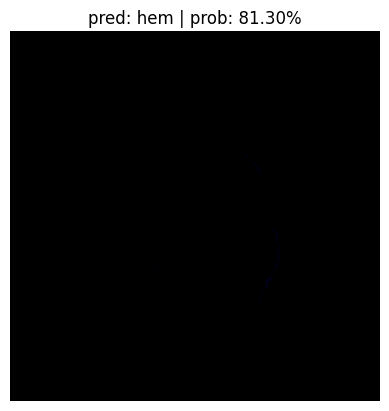

In [27]:
prediction, preds_percent = pred_plot_image(model=model,
                    image_path=random.choice(list(test_final_dir.glob("*/*.bmp"))),
                    class_name=["hem", "all"],
                    transform=val_transform)

In [28]:
prediction, preds_percent

('hem', 81.30114078521729)

## Langchain, RAG 

In [32]:
url = [
    "https://pubmed.ncbi.nlm.nih.gov/25435111/",
    "https://pubmed.ncbi.nlm.nih.gov/31657974/",
    "https://pubmed.ncbi.nlm.nih.gov/32247396/"
    # "https://en.wikipedia.org/wiki/Acute_lymphoblastic_leukemia"
]

In [47]:
from langchain_community.document_loaders import WebBaseLoader

# urls = [
#     "https://pubmed.ncbi.nlm.nih.gov/25435111/",
#     "https://pubmed.ncbi.nlm.nih.gov/31657974/",
#     "https://pubmed.ncbi.nlm.nih.gov/32247396/",
#     "https://en.wikipedia.org/wiki/Acute_lymphoblastic_leukemia"
# ]

urls = ["https://my.clevelandclinic.org/health/diseases/21564-acute-lymphocytic-leukemia"]

loader = WebBaseLoader(urls)
docs = loader.load()
print(len(docs))

1


In [50]:
with open("docs_cache.txt", "w", encoding="utf-8") as f:
    for doc in docs:
        f.write(doc.page_content + "\n\n")